In [9]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

10504699904
0
0


In [10]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/2023-09-09/


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [12]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), 
        ], p=1),
        A.Resize(640, 480),  # Resize every image to 640x480 after all other transformations
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [13]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [14]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the arm
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_kp')
            bboxes_labels_original.append('joint1')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')

        if self.transform:
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj):
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original  

            # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]   
#         labels = [1, 2, 3, 4]
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)


        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    

In [15]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 19410.85 files/s]


[[[257, 366]], [[257, 283]], [[232, 207]], [[252, 200]], [[216, 108]], [[203, 89]]]
0
[[257, 366]]
[257, 366]
1
[[257, 283]]
[257, 283]
2
[[232, 207]]
[232, 207]
3
[[252, 200]]
[252, 200]
4
[[216, 108]]
[216, 108]
5
[[203, 89]]
[203, 89]


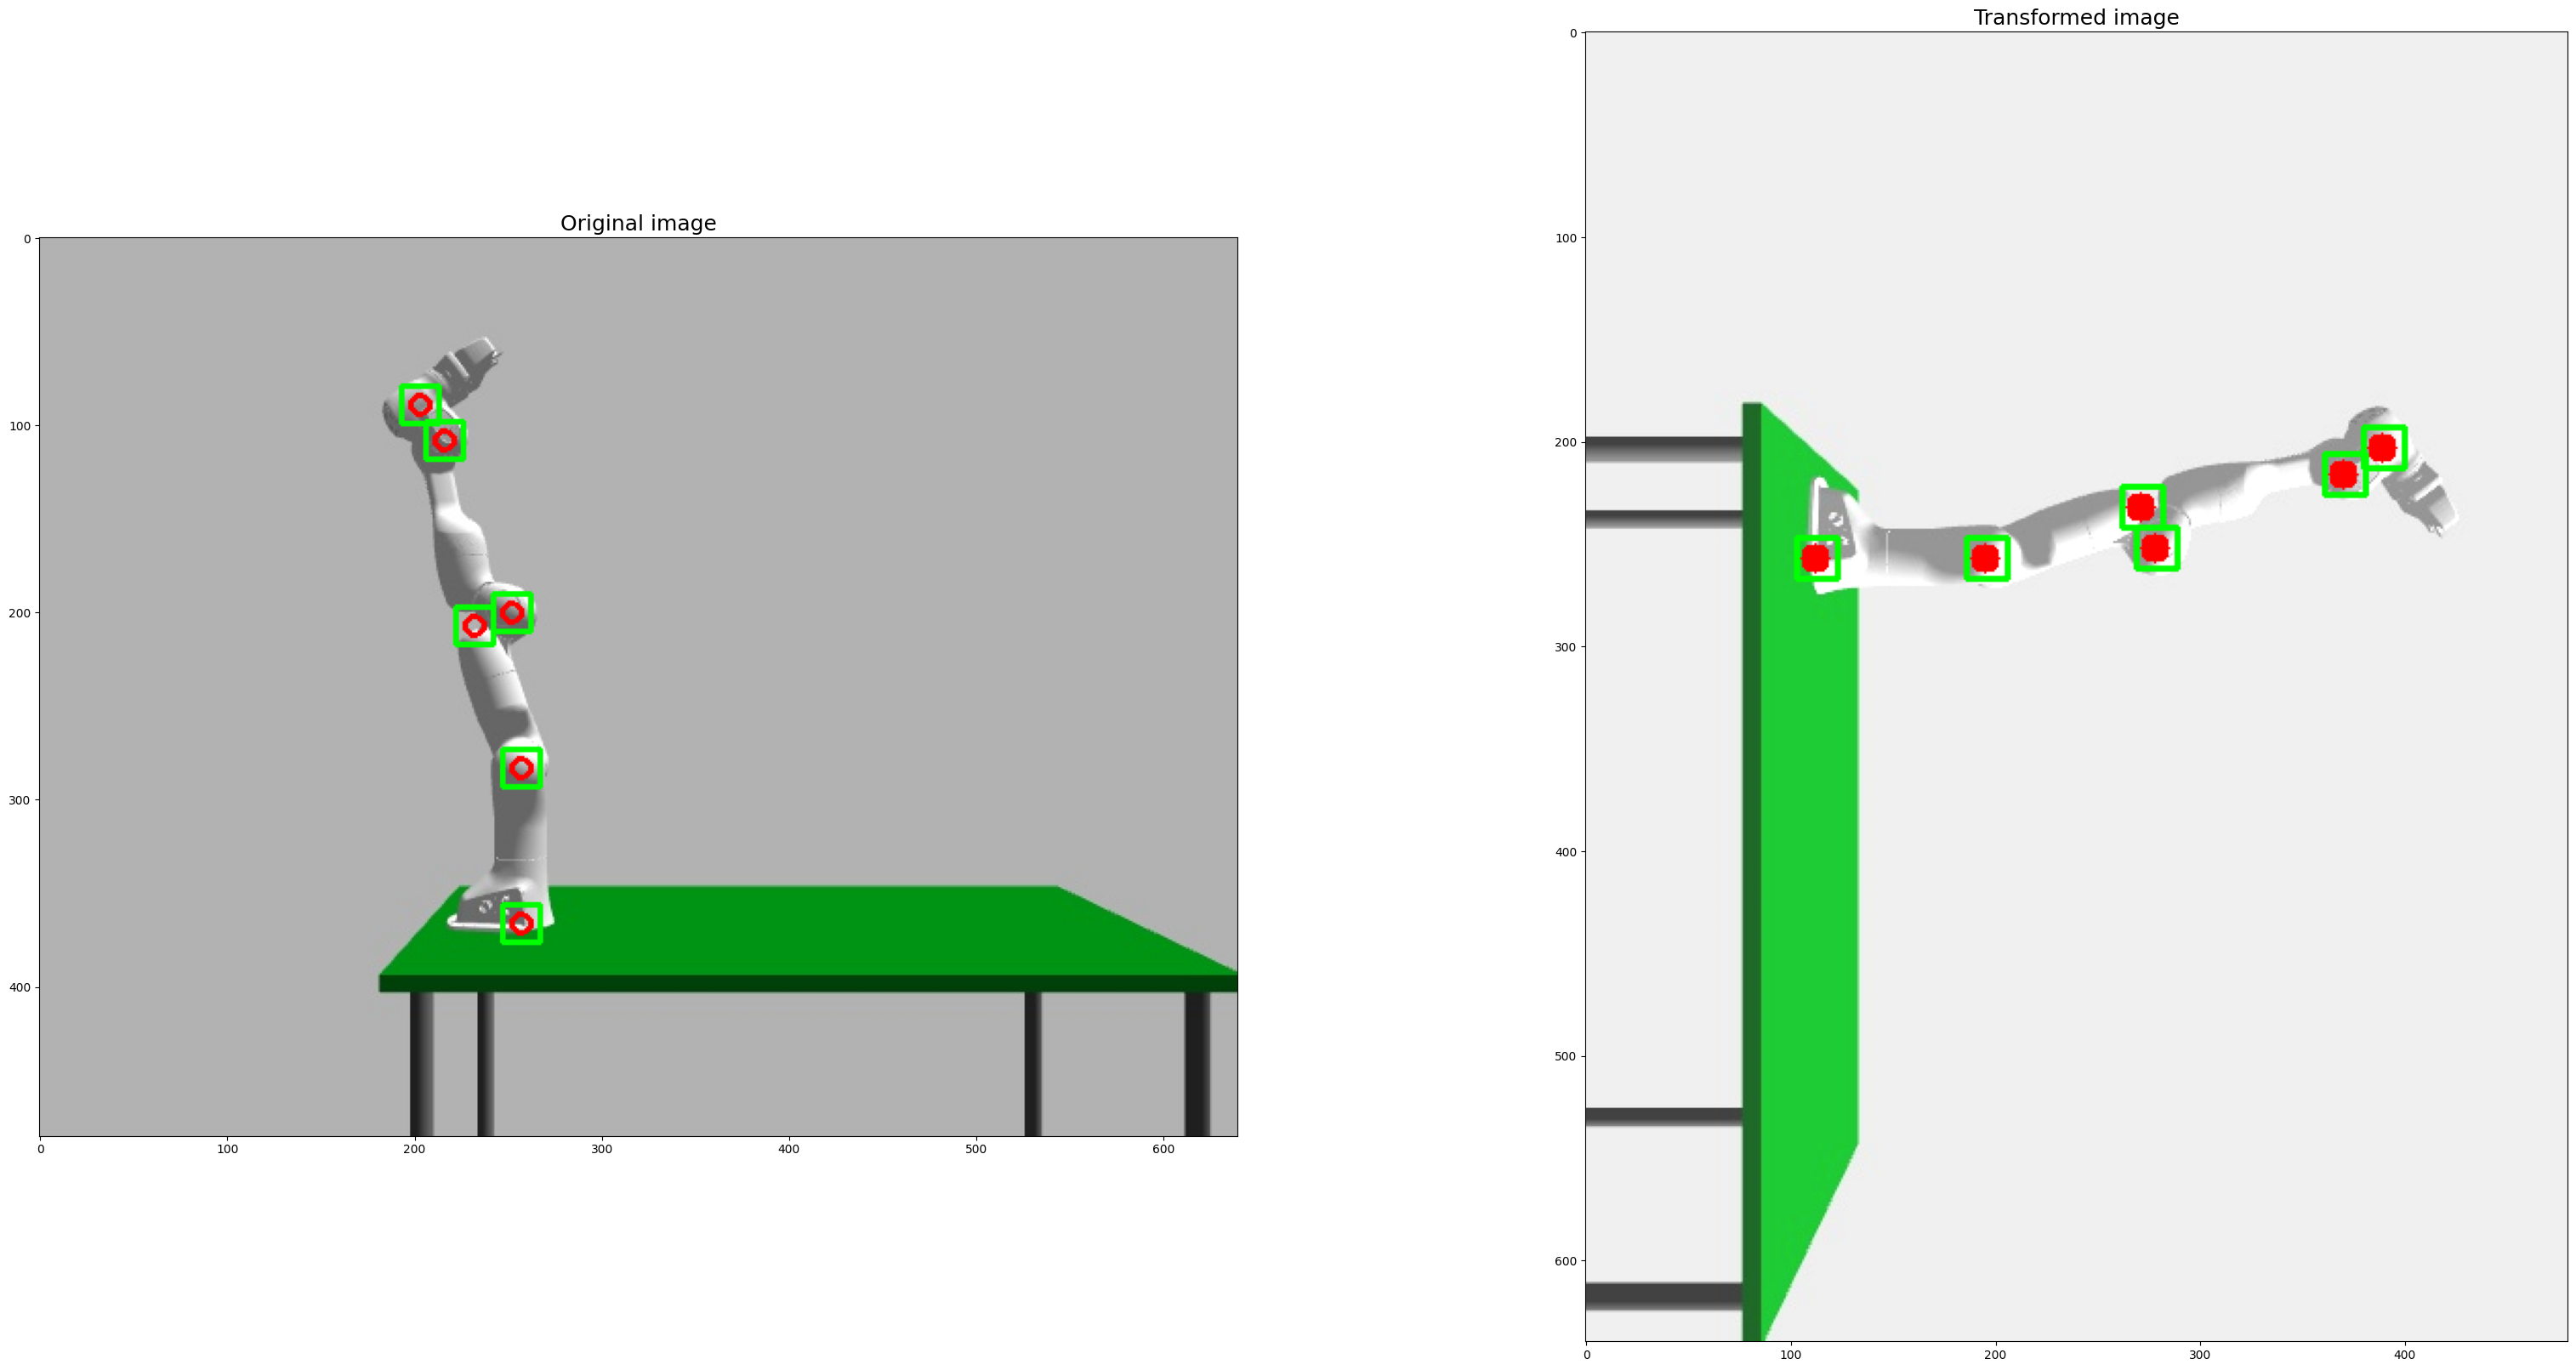

In [16]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [17]:
# def get_model(num_keypoints, weights_path=None):
    
#     anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
#     model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
#                                                                    pretrained_backbone=True,
#                                                                    num_keypoints=num_keypoints,
#                                                                    num_classes = 4, # Background is the first class, object is the second class
#                                                                    rpn_anchor_generator=anchor_generator)

#     if weights_path:
#         state_dict = torch.load(weights_path)
#         model.load_state_dict(state_dict)        
        
#     return model

In [18]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
        print("shape of x", x.shape)
        print("shape of adj", adj.shape)
        batch_size = adj.size(0)  # Assuming adj_matrix has a shape of [batch_size, 4, 4]
        if x.dim() == 2:
            # It means we have the shape [4, 3] for x, adjust accordingly
            x = x.unsqueeze(0).expand(batch_size, -1, -1)
        else:
            # We assume the shape is [4, 4, 128]
            "Do Nothing"
        out = torch.bmm(adj, x)
        out = self.fc(out)
        return out

In [19]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.keypoint_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(
            pretrained=False, pretrained_backbone=True, num_keypoints=6, num_classes=7)
        self.graph_conv1 = GraphConv(3, 128)
        self.graph_conv2 = GraphConv(128, 3)
    
    def complete_missing_keypoints(self, keypoints, labels, num_expected_keypoints=6):

        detected_kps = keypoints.shape[0]
        print(labels)
        # Check if all keypoints are detected
        if detected_kps == num_expected_keypoints:
            return keypoints
        
        if detected_kps == 0:
            # Placeholder: If no keypoints are detected, set to center or other static position
            default_value = torch.tensor([320, 240, 1], device=keypoints.device)
            missing_kps_tensor = torch.full((num_expected_keypoints, keypoints.shape[1]), default_value)
            return missing_kps_tensor
        
        # Create a placeholder tensor for keypoints with the correct shape
        ordered_keypoints = torch.zeros((num_expected_keypoints, 3), device=keypoints.device)

        # If some keypoints are detected, compute their average position
        average_kp = torch.mean(keypoints, dim=0, keepdim=True)

        for i, label in enumerate(labels):
            ordered_keypoints[label - 1] = keypoints[i]

        # Fill in the missing keypoints with the average position
        missing_indices = (torch.sum(ordered_keypoints, dim=1) == 0).nonzero(as_tuple=True)[0]
        ordered_keypoints[missing_indices] = average_kp

        return ordered_keypoints

    def forward(self, images, adj_matrix=None, targets=None, train=False):
        if train:
            output = self.keypoint_rcnn(images, targets)
            return output  # This contains the losses during training
        else:
            with torch.no_grad():  # Deactivates autograd, reduces memory usage and speeds up computations
                self.keypoint_rcnn.eval()  # Set to evaluation mode
                output = self.keypoint_rcnn(images)
                self.keypoint_rcnn.train()  # Revert to training mode
            keypoints = output[0]['keypoints'].detach().cpu().numpy()
            kp_score = output[0]['keypoints_scores'].detach().cpu().numpy()
            
            labels = output[0]['labels'].detach().cpu().numpy()                
            unique_labels = list(set(labels))
            scores = output[0]['scores'].detach().cpu().numpy()      
            
            kps = []
            kp_scores = []
            ulabels = []
            
            for label in unique_labels:
                #find the index with highest score for this label
                indices = [i for i,x in enumerate(labels) if x == label]
                scores_for_label = [scores[i] for i in indices]
                max_score_index = indices[scores_for_label.index(max(scores_for_label))]
                kp_score_label = kp_score[max_score_index].tolist()
                # Add corresponding box, keypoint, and label to the result                
                kps.append(keypoints[max_score_index][kp_score_label.index(max(kp_score_label))])  
                ulabels.append(label)
            
            kps = [torch.tensor(kp, dtype=torch.float32) for kp in kps]
            
            keypoints = torch.stack(kps)
#             print("kp before placeholder", keypoints)
            
            keypoints = self.complete_missing_keypoints(keypoints, unique_labels, num_expected_keypoints=6)            
#             print("keypoints with placeholder", keypoints)
            
            keypoints = self.graph_conv1(keypoints, adj_matrix)
            keypoints = nn.functional.relu(keypoints)
            keypoints = self.graph_conv2(keypoints, adj_matrix)

            return keypoints 


In [20]:
def custom_loss(predicted_keypoints, gt_keypoints, adj_matrix, loss_keypoint):
    mse_loss = nn.MSELoss()
    batch_size = adj_matrix.size(0)
#     gt_keypoints = gt_keypoints.repeat(batch_size, 1, 1)
    print("predicted_keypoints shape:", predicted_keypoints.shape)
    print("gt_keypoints shape:", gt_keypoints.shape)
    print("adj_matrix shape:", adj_matrix.shape)
    keypoint_loss = mse_loss(predicted_keypoints, gt_keypoints)
    #     box_loss = mse_loss(predicted_boxes, gt_boxes)
    # Compute pairwise differences
    diff = predicted_keypoints.unsqueeze(2) - gt_keypoints.unsqueeze(1)  # shape [1, 4, 4, 3]
    # Square the differences
    squared_diff = diff**2  # shape [1, 4, 4, 3]
    # Sum over the coordinate dimension (i.e., sum the squared differences for x, y, z coordinates)
    squared_diff_summed = squared_diff.sum(dim=-1)  # shape [1, 4, 4]
    # Use adjacency matrix to mask out unwanted differences and compute the graph loss
    graph_loss = torch.sum((1 - adj_matrix) * squared_diff_summed)    
#     graph_loss = torch.sum((1 - adj_matrix) * (predicted_keypoints - gt_keypoints)**2)
    
#     total_loss = keypoint_loss + 0.1 * box_loss + 0.01 * graph_loss + loss_keypoint
    total_loss = keypoint_loss + graph_loss + loss_keypoint
    
    return total_loss


In [21]:
def create_adjacency_matrix(num_keypoints):
    # Initialize a zero matrix
    adj_matrix = torch.zeros((num_keypoints, num_keypoints))
    
    # Fill the diagonal above the main diagonal with ones
    for i in range(num_keypoints - 1):
        adj_matrix[i, i + 1] = 1
        
    return adj_matrix


In [22]:
# Initialize model and optimizer
model = CombinedModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create adjacency matrix
num_keypoints = 6
adj_matrix = create_adjacency_matrix(num_keypoints)


/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the fu

In [23]:
num_epochs = 30
batch_size = 1

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

top_5_models = []

for epoch in range(num_epochs):  # for 50 epochs
    for batch_idx, batch in enumerate(data_loader_train):
        images, targets = batch  
        ground_truth_keypoints = [target['keypoints'] for target in targets]
        ground_truth_boxes = [target['boxes'] for target in targets]
        
        # Assuming you want all images to be of size [3, 640, 480]
#         desired_size = (640, 480)  

        # Resize all images to the desired size
#         resized_images = [F.resize(img, desired_size) for img in images]

        # Now stack the resized images
#         images = torch.stack(resized_images)
        images = torch.stack(images)
        ground_truth_keypoints = torch.stack(ground_truth_keypoints).squeeze()
        ground_truth_boxes = torch.stack(ground_truth_boxes)

#         Create a batched adjacency matrix with the same batch size
        batch_adj_matrix = adj_matrix.repeat(batch_size, 1, 1)
        print(batch_adj_matrix.shape)
        
        optimizer.zero_grad()
        
        # Forward pass for training
        output_train = model(images, adj_matrix=batch_adj_matrix, targets=targets, train=True)
        print("Output keypoints shape", output_train.keys())
        
        #Forward pass for loss
        predicted_keypoints = model(images, adj_matrix=batch_adj_matrix, train=False)
        
        
        print("predicted keypoints", predicted_keypoints.shape)
                
        loss_keypoint = output_train['loss_keypoint']
        
        # Compute loss and backpropagate
        loss = custom_loss(predicted_keypoints, ground_truth_keypoints, 
                           adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
        
        loss.backward()
        optimizer.step()
        
        # Check if the current model should be saved as a top model
        if len(top_5_models) < 5 or loss.item() < max(top_5_models, key=lambda x: x[0])[0]:
            # Save the model state and loss
            model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }
            top_5_models.append((loss.item(), model_state))

            # Sort the list based on loss (ascending order)
            top_5_models.sort(key=lambda x: x[0])

            # If there are more than 5 models, remove the one with the highest loss
            if len(top_5_models) > 5:
                top_5_models.pop()

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader_train)}, Loss: {loss.item()}")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# After all epochs, save the top 5 models to disk
for idx, (_, model_state) in enumerate(top_5_models):
    torch.save(model_state, f'best_model_{idx+1}.pth')


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 15918.89 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 15925.45 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09


Copying files: 2662 files [00:00, 16143.20 files/s]

torch.Size([1, 6, 6])


Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


/home/jc-merlab/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 3])) that is different to the input size (torch.Size([1, 6, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Batch 1/931, Loss: 4523872.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 2/931, Loss: 5886270.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoc

Epoch 1/30, Batch 18/931, Loss: 3880622.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 19/931, Loss: 5257381.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
E

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 35/931, Loss: 5827902.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 36/931, Loss: 4846189.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 1/30, Batch 51/931, Loss: 4291504.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 52/931, Loss: 4436211.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Ep

Epoch 1/30, Batch 68/931, Loss: 5444325.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 69/931, Loss: 4377328.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 85/931, Loss: 4525957.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 86/931, Loss: 7070672.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 1/30, Batch 101/931, Loss: 3518741.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 102/931, Loss: 4620496.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 118/931, Loss: 4499174.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 119/931, Loss: 3410026.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 1/30, Batch 134/931, Loss: 5425254.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 135/931, Loss: 3853459.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 151/931, Loss: 3763289.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 152/931, Loss: 3738804.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 1/30, Batch 167/931, Loss: 1244575.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 168/931, Loss: 2370481.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 184/931, Loss: 3029389.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 185/931, Loss: 2917941.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 1/30, Batch 200/931, Loss: 3653304.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 201/931, Loss: 1690371.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 217/931, Loss: 2896038.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 218/931, Loss: 3610942.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 1/30, Batch 233/931, Loss: 4060145.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 234/931, Loss: 4124281.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 250/931, Loss: 1608490.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 251/931, Loss: 3495591.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 266/931, Loss: 2013937.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 267/931, Loss: 2116742.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 283/931, Loss: 2881473.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 284/931, Loss: 1182415.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 1/30, Batch 299/931, Loss: 1873576.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 300/931, Loss: 1508012.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 316/931, Loss: 940834.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 317/931, Loss: 4102190.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 1/30, Batch 332/931, Loss: 1947547.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 333/931, Loss: 3002428.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 349/931, Loss: 3439453.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 350/931, Loss: 2793456.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 365/931, Loss: 1387580.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 366/931, Loss: 2468562.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 382/931, Loss: 1903822.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 383/931, Loss: 1594679.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 398/931, Loss: 847355.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 399/931, Loss: 2795580.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 415/931, Loss: 1764272.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 416/931, Loss: 2119980.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 1/30, Batch 431/931, Loss: 2935828.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 432/931, Loss: 1980913.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 448/931, Loss: 2972721.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 449/931, Loss: 979971.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/30, Batch 464/931, Loss: 1920122.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 465/931, Loss: 2302479.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 481/931, Loss: 2896777.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 482/931, Loss: 1205102.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 1/30, Batch 497/931, Loss: 1517046.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 498/931, Loss: 2025547.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 514/931, Loss: 1549490.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 515/931, Loss: 832818.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 1/30, Batch 530/931, Loss: 3079596.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 531/931, Loss: 2184276.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 547/931, Loss: 1540120.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 548/931, Loss: 2389511.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 563/931, Loss: 1465556.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 564/931, Loss: 1413615.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 580/931, Loss: 815958.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 581/931, Loss: 1583427.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 1/30, Batch 596/931, Loss: 2116186.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 597/931, Loss: 4140080.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 613/931, Loss: 3087520.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 614/931, Loss: 2087482.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 629/931, Loss: 2575630.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 630/931, Loss: 2690894.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 646/931, Loss: 3158204.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 647/931, Loss: 3441063.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 1/30, Batch 662/931, Loss: 3345150.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 663/931, Loss: 2990742.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 679/931, Loss: 1170203.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 680/931, Loss: 2146983.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 1/30, Batch 695/931, Loss: 2967602.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 696/931, Loss: 2141024.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 712/931, Loss: 846126.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 713/931, Loss: 2477435.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 1/30, Batch 728/931, Loss: 1723529.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 729/931, Loss: 2516864.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 745/931, Loss: 1956481.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 746/931, Loss: 2881067.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 1/30, Batch 761/931, Loss: 2893503.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 762/931, Loss: 1936261.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 778/931, Loss: 2745377.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 779/931, Loss: 2824894.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 794/931, Loss: 2315471.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 795/931, Loss: 2215614.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 811/931, Loss: 3243610.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 812/931, Loss: 3131254.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 1/30, Batch 827/931, Loss: 1373364.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 828/931, Loss: 3408124.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 844/931, Loss: 1184932.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 845/931, Loss: 861880.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 860/931, Loss: 3595792.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 861/931, Loss: 2114278.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 877/931, Loss: 1295944.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 878/931, Loss: 723555.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 893/931, Loss: 2067843.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 894/931, Loss: 3271286.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 910/931, Loss: 1367093.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 911/931, Loss: 1039729.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 1/30, Batch 926/931, Loss: 2692604.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 1/30, Batch 927/931, Loss: 2847368.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 12/931, Loss: 3053302.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 13/931, Loss: 2308777.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 28/931, Loss: 1443888.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 29/931, Loss: 1773721.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 45/931, Loss: 2024962.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 46/931, Loss: 1836817.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 61/931, Loss: 2348431.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 62/931, Loss: 1504125.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 78/931, Loss: 1632383.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 79/931, Loss: 1032803.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 2/30, Batch 94/931, Loss: 1882919.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 95/931, Loss: 2294078.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 111/931, Loss: 1387941.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 112/931, Loss: 1659388.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 2/30, Batch 127/931, Loss: 1885713.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 128/931, Loss: 4546994.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 144/931, Loss: 2232311.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 145/931, Loss: 3514860.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 2/30, Batch 160/931, Loss: 2372684.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 161/931, Loss: 2034628.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 177/931, Loss: 1527687.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 178/931, Loss: 2408047.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 2/30, Batch 193/931, Loss: 2351875.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 194/931, Loss: 2064473.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 210/931, Loss: 3041517.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 211/931, Loss: 1519250.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 2/30, Batch 226/931, Loss: 1863492.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 227/931, Loss: 2913827.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 243/931, Loss: 2044194.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 244/931, Loss: 3027855.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 2/30, Batch 259/931, Loss: 969191.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 260/931, Loss: 1614370.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 276/931, Loss: 4080806.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 277/931, Loss: 2734131.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 2/30, Batch 292/931, Loss: 3011596.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 293/931, Loss: 1894429.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 309/931, Loss: 1207637.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 310/931, Loss: 1444477.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 2/30, Batch 325/931, Loss: 1961147.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 326/931, Loss: 2487877.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 342/931, Loss: 1231668.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 343/931, Loss: 1363078.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 2/30, Batch 358/931, Loss: 2701219.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 359/931, Loss: 2470354.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 375/931, Loss: 2365822.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 376/931, Loss: 1568154.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 2/30, Batch 391/931, Loss: 4304255.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 392/931, Loss: 3500189.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 408/931, Loss: 1390850.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 409/931, Loss: 1373931.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 424/931, Loss: 1882674.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 425/931, Loss: 2245764.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 441/931, Loss: 2020434.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 442/931, Loss: 3039999.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 2/30, Batch 457/931, Loss: 2188465.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 458/931, Loss: 2812351.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 474/931, Loss: 1962158.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 475/931, Loss: 882473.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 2/30, Batch 490/931, Loss: 2738976.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 491/931, Loss: 2306439.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 507/931, Loss: 3270648.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 508/931, Loss: 1193333.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 2/30, Batch 523/931, Loss: 4071776.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 524/931, Loss: 3279909.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 540/931, Loss: 1940633.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 541/931, Loss: 4093966.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 556/931, Loss: 3136246.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 557/931, Loss: 1333622.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 573/931, Loss: 3169557.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 574/931, Loss: 2065038.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 2/30, Batch 589/931, Loss: 1684198.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 590/931, Loss: 2970910.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 606/931, Loss: 1879310.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 607/931, Loss: 2933325.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 2/30, Batch 622/931, Loss: 3388360.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 623/931, Loss: 2491585.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 639/931, Loss: 1603573.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 640/931, Loss: 3248378.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 2/30, Batch 655/931, Loss: 2896323.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 656/931, Loss: 2283183.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 672/931, Loss: 2932312.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 673/931, Loss: 1493707.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 2/30, Batch 688/931, Loss: 2158622.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 689/931, Loss: 2598789.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 705/931, Loss: 3810827.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 706/931, Loss: 2169751.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 2/30, Batch 721/931, Loss: 2517340.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 722/931, Loss: 1689102.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 738/931, Loss: 2239344.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 739/931, Loss: 3258741.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 2/30, Batch 754/931, Loss: 1343273.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 755/931, Loss: 2555089.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 771/931, Loss: 4301973.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 772/931, Loss: 1743657.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 2/30, Batch 787/931, Loss: 1319921.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 788/931, Loss: 1629867.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 804/931, Loss: 3140846.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 805/931, Loss: 1552287.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 2/30, Batch 820/931, Loss: 1902932.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 821/931, Loss: 1949955.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 837/931, Loss: 2622279.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 838/931, Loss: 2412813.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 2/30, Batch 853/931, Loss: 2292521.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 854/931, Loss: 2123676.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 870/931, Loss: 1961527.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 871/931, Loss: 1700046.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 2/30, Batch 886/931, Loss: 1443207.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 887/931, Loss: 1667719.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 903/931, Loss: 2934415.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 904/931, Loss: 2940726.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 2/30, Batch 919/931, Loss: 839381.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 2/30, Batch 920/931, Loss: 964117.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 5/931, Loss: 2879483.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 6/931, Loss: 1197432.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 3/30, Batch 21/931, Loss: 2154878.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 22/931, Loss: 1804310.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 38/931, Loss: 844270.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 39/931, Loss: 2091300.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 3/30, Batch 54/931, Loss: 1414064.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 55/931, Loss: 2535458.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 71/931, Loss: 1634819.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 72/931, Loss: 2998250.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 3/30, Batch 87/931, Loss: 2301488.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 88/931, Loss: 1225838.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 104/931, Loss: 1499606.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 105/931, Loss: 1142779.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 3/30, Batch 120/931, Loss: 2162376.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 121/931, Loss: 3624470.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 137/931, Loss: 2995902.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 138/931, Loss: 1875749.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 3/30, Batch 153/931, Loss: 1826791.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 154/931, Loss: 2029213.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 170/931, Loss: 1692410.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 171/931, Loss: 1859609.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 3/30, Batch 186/931, Loss: 1976879.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 187/931, Loss: 1456513.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 203/931, Loss: 3281824.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 204/931, Loss: 2774989.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 3/30, Batch 219/931, Loss: 625123.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 220/931, Loss: 2172892.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 236/931, Loss: 2254236.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 237/931, Loss: 1110103.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 3/30, Batch 252/931, Loss: 3011391.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 253/931, Loss: 2223198.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 269/931, Loss: 2158942.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 270/931, Loss: 2222713.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 3/30, Batch 285/931, Loss: 3400779.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 286/931, Loss: 3201779.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 302/931, Loss: 1439209.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 303/931, Loss: 3546122.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 3/30, Batch 318/931, Loss: 3877271.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 319/931, Loss: 1878981.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 335/931, Loss: 3566261.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 336/931, Loss: 1381075.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 3/30, Batch 351/931, Loss: 1455035.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 352/931, Loss: 2103022.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 368/931, Loss: 1024419.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 369/931, Loss: 1418798.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'los

Epoch 3/30, Batch 384/931, Loss: 1463730.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 385/931, Loss: 1779687.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 401/931, Loss: 3441837.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 402/931, Loss: 1122785.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 3/30, Batch 417/931, Loss: 1088438.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 418/931, Loss: 2602636.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 434/931, Loss: 3303939.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 435/931, Loss: 793643.5625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 3/30, Batch 450/931, Loss: 1050249.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 451/931, Loss: 1328197.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 467/931, Loss: 2588362.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 468/931, Loss: 1353597.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 3/30, Batch 483/931, Loss: 1573062.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 484/931, Loss: 1186025.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 500/931, Loss: 2525645.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 501/931, Loss: 1128836.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 3/30, Batch 516/931, Loss: 1030240.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 517/931, Loss: 1561752.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 533/931, Loss: 1536467.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 534/931, Loss: 1103119.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 3/30, Batch 549/931, Loss: 1259549.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 550/931, Loss: 2701601.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 566/931, Loss: 1063616.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 567/931, Loss: 3581552.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 3/30, Batch 582/931, Loss: 3415180.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 583/931, Loss: 1024713.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 599/931, Loss: 2616718.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 600/931, Loss: 2254086.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 3/30, Batch 615/931, Loss: 1398721.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 616/931, Loss: 3797844.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 632/931, Loss: 874466.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 633/931, Loss: 977392.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 3/30, Batch 648/931, Loss: 2356607.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 649/931, Loss: 3120403.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 665/931, Loss: 2266861.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 666/931, Loss: 1623070.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 3/30, Batch 681/931, Loss: 1494880.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 682/931, Loss: 1543755.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 698/931, Loss: 1803212.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 699/931, Loss: 2556751.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 3/30, Batch 714/931, Loss: 1317518.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 715/931, Loss: 1877420.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 731/931, Loss: 2873744.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 732/931, Loss: 1183426.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 3/30, Batch 747/931, Loss: 1027545.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 748/931, Loss: 1259518.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 764/931, Loss: 4190888.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 765/931, Loss: 3501331.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 3/30, Batch 780/931, Loss: 865334.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 781/931, Loss: 3471002.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 797/931, Loss: 1160130.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 798/931, Loss: 3257019.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 3/30, Batch 813/931, Loss: 747620.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 814/931, Loss: 1943658.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 830/931, Loss: 1776880.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 831/931, Loss: 4235925.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 3/30, Batch 846/931, Loss: 1415200.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 847/931, Loss: 1218451.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 863/931, Loss: 1080715.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 864/931, Loss: 1299337.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 3/30, Batch 879/931, Loss: 1262715.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 880/931, Loss: 1077620.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 896/931, Loss: 1699495.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 897/931, Loss: 2859527.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 3/30, Batch 912/931, Loss: 2148181.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 913/931, Loss: 1817514.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 929/931, Loss: 1679469.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 3/30, Batch 930/931, Loss: 1931769.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 4/30, Batch 14/931, Loss: 1119161.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 15/931, Loss: 2793307.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 31/931, Loss: 3129740.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 32/931, Loss: 678872.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 4/30, Batch 47/931, Loss: 1229402.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 48/931, Loss: 2254078.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 64/931, Loss: 1615412.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 65/931, Loss: 2357469.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 4/30, Batch 80/931, Loss: 2708171.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 81/931, Loss: 3351147.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 97/931, Loss: 1927340.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 98/931, Loss: 2005503.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 4/30, Batch 113/931, Loss: 2113710.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 114/931, Loss: 4039386.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 130/931, Loss: 1921977.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 131/931, Loss: 1376878.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 4/30, Batch 146/931, Loss: 2159460.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 147/931, Loss: 3900832.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 163/931, Loss: 2040058.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 164/931, Loss: 1096585.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 4/30, Batch 179/931, Loss: 1686616.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 180/931, Loss: 1836625.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 196/931, Loss: 1851566.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 197/931, Loss: 3247796.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 4/30, Batch 212/931, Loss: 2523732.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 213/931, Loss: 2923133.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 229/931, Loss: 621885.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 230/931, Loss: 3927346.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 4/30, Batch 245/931, Loss: 2015617.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 246/931, Loss: 1024080.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 262/931, Loss: 1808833.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 263/931, Loss: 1688924.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 4/30, Batch 278/931, Loss: 1421531.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 279/931, Loss: 1090134.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 295/931, Loss: 1561038.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 296/931, Loss: 807588.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 4/30, Batch 311/931, Loss: 3545539.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 312/931, Loss: 2937730.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 328/931, Loss: 1778894.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 329/931, Loss: 1684520.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 4/30, Batch 344/931, Loss: 2509326.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 345/931, Loss: 1867517.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 361/931, Loss: 2198141.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 362/931, Loss: 3029998.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 4/30, Batch 377/931, Loss: 3947163.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 378/931, Loss: 1417006.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torc

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 394/931, Loss: 1939000.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 395/931, Loss: 1632429.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss

Epoch 4/30, Batch 410/931, Loss: 627910.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 411/931, Loss: 2591084.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 427/931, Loss: 2579829.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 428/931, Loss: 2226723.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 4/30, Batch 443/931, Loss: 2268542.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 444/931, Loss: 1949771.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 460/931, Loss: 1223110.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 461/931, Loss: 1181255.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 4/30, Batch 476/931, Loss: 2590965.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 477/931, Loss: 2729228.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 493/931, Loss: 1835438.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 494/931, Loss: 2066006.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 4/30, Batch 509/931, Loss: 2747919.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 510/931, Loss: 624752.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 526/931, Loss: 827909.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 527/931, Loss: 3093219.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 4/30, Batch 542/931, Loss: 2133994.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 543/931, Loss: 1875136.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 559/931, Loss: 2157863.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 560/931, Loss: 1685376.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 4/30, Batch 575/931, Loss: 1841058.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 576/931, Loss: 2708922.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 592/931, Loss: 3353864.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 593/931, Loss: 2565773.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 4/30, Batch 608/931, Loss: 2133285.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 609/931, Loss: 3947098.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 625/931, Loss: 1823324.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 626/931, Loss: 1378863.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 4/30, Batch 641/931, Loss: 3200403.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 642/931, Loss: 1974216.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 658/931, Loss: 2244412.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 659/931, Loss: 2321808.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 4/30, Batch 674/931, Loss: 2229960.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 675/931, Loss: 1337256.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 691/931, Loss: 3039382.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 692/931, Loss: 1869655.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 4/30, Batch 707/931, Loss: 3130476.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 708/931, Loss: 2775354.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 724/931, Loss: 2528930.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 725/931, Loss: 1701097.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 4/30, Batch 740/931, Loss: 2050993.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 741/931, Loss: 2819990.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 757/931, Loss: 1557450.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 758/931, Loss: 3175468.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 4/30, Batch 773/931, Loss: 3254278.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 774/931, Loss: 2205804.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 790/931, Loss: 895086.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 791/931, Loss: 1436307.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 4/30, Batch 806/931, Loss: 1783993.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 807/931, Loss: 1800132.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 823/931, Loss: 2148362.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 824/931, Loss: 2478686.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 4/30, Batch 839/931, Loss: 1585096.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 840/931, Loss: 993911.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 856/931, Loss: 1305252.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 857/931, Loss: 3749119.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 4/30, Batch 872/931, Loss: 3889732.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 873/931, Loss: 1086324.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 889/931, Loss: 1950250.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 890/931, Loss: 2428900.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 4/30, Batch 905/931, Loss: 2985186.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 906/931, Loss: 1096121.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 922/931, Loss: 3321426.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 4/30, Batch 923/931, Loss: 2961374.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 5/30, Batch 7/931, Loss: 3653284.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 8/931, Loss: 1790342.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 24/931, Loss: 1663774.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 25/931, Loss: 2433002.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 5/30, Batch 40/931, Loss: 2545621.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 41/931, Loss: 2179985.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 57/931, Loss: 2039850.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 58/931, Loss: 2554791.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 5/30, Batch 73/931, Loss: 1864454.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 74/931, Loss: 2818545.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 90/931, Loss: 2448219.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 91/931, Loss: 1442969.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 5/30, Batch 106/931, Loss: 1965251.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 107/931, Loss: 1255657.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 123/931, Loss: 3983724.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 124/931, Loss: 1071291.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 5/30, Batch 139/931, Loss: 2727789.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 140/931, Loss: 2655767.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 156/931, Loss: 1716293.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 157/931, Loss: 1781388.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 5/30, Batch 172/931, Loss: 1523166.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 173/931, Loss: 2479979.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 189/931, Loss: 1583465.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 190/931, Loss: 2590622.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 5/30, Batch 205/931, Loss: 782947.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 206/931, Loss: 2992682.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 222/931, Loss: 4224819.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 223/931, Loss: 1897967.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 5/30, Batch 238/931, Loss: 3473357.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 239/931, Loss: 2703568.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 255/931, Loss: 2125512.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 256/931, Loss: 2173778.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 5/30, Batch 271/931, Loss: 1080106.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 272/931, Loss: 3177327.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 288/931, Loss: 1456026.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 289/931, Loss: 2895477.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 5/30, Batch 304/931, Loss: 1961135.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 305/931, Loss: 2506334.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 321/931, Loss: 1082052.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 322/931, Loss: 1999827.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 5/30, Batch 337/931, Loss: 1045824.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 338/931, Loss: 2673089.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 354/931, Loss: 1774120.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 355/931, Loss: 2241429.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 5/30, Batch 370/931, Loss: 2579876.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 371/931, Loss: 2153216.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 387/931, Loss: 2865435.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 388/931, Loss: 2124379.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 5/30, Batch 403/931, Loss: 1935815.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 404/931, Loss: 1730325.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 420/931, Loss: 3143052.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 421/931, Loss: 746413.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 5/30, Batch 436/931, Loss: 1127389.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 437/931, Loss: 3991945.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 453/931, Loss: 3900429.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 454/931, Loss: 2536191.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 5/30, Batch 469/931, Loss: 2423291.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 470/931, Loss: 3075006.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 486/931, Loss: 3045131.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 487/931, Loss: 2011936.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 5/30, Batch 502/931, Loss: 1935039.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 503/931, Loss: 1743321.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 519/931, Loss: 1233425.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 520/931, Loss: 1219456.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 5/30, Batch 535/931, Loss: 2343817.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 536/931, Loss: 1279306.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 552/931, Loss: 1141109.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 553/931, Loss: 1151044.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 5/30, Batch 568/931, Loss: 3181921.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 569/931, Loss: 2264122.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 585/931, Loss: 772469.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 586/931, Loss: 2927666.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 5/30, Batch 601/931, Loss: 2357719.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 602/931, Loss: 2653583.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 618/931, Loss: 1357827.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 619/931, Loss: 2990307.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 5/30, Batch 634/931, Loss: 1626927.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 635/931, Loss: 1113198.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 651/931, Loss: 3157505.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 652/931, Loss: 1522923.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 5/30, Batch 667/931, Loss: 3845043.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 668/931, Loss: 2069241.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 684/931, Loss: 1884179.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 685/931, Loss: 1134101.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 5/30, Batch 700/931, Loss: 2323458.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 701/931, Loss: 2835907.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 717/931, Loss: 2438958.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 718/931, Loss: 1003835.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 5/30, Batch 733/931, Loss: 3084444.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 734/931, Loss: 1004610.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 750/931, Loss: 2183604.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 751/931, Loss: 2612956.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 5/30, Batch 766/931, Loss: 2170095.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 767/931, Loss: 2053339.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 783/931, Loss: 1741169.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 784/931, Loss: 1412214.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_

Epoch 5/30, Batch 799/931, Loss: 3815498.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 800/931, Loss: 4105275.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 816/931, Loss: 1436328.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 817/931, Loss: 1532637.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 5/30, Batch 832/931, Loss: 1039393.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 833/931, Loss: 2583709.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 849/931, Loss: 3653009.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 850/931, Loss: 2859127.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 5/30, Batch 865/931, Loss: 2795973.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 866/931, Loss: 3746516.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 882/931, Loss: 2940343.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 883/931, Loss: 1788991.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 5/30, Batch 898/931, Loss: 1194136.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 899/931, Loss: 1382030.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 915/931, Loss: 1320916.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 5/30, Batch 916/931, Loss: 2554450.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 5/30, Batch 931/931, Loss: 2223689.75
Epoch 5/30, Loss: 2223689.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 1/931, Loss: 3429988.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 17/931, Loss: 1778140.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 18/931, Loss: 608039.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 6/30, Batch 33/931, Loss: 1401218.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 34/931, Loss: 2342113.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 50/931, Loss: 3872974.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 51/931, Loss: 806979.5625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 6/30, Batch 66/931, Loss: 1861889.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 67/931, Loss: 1233492.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 83/931, Loss: 1080158.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 84/931, Loss: 1887038.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 6/30, Batch 99/931, Loss: 1356539.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 100/931, Loss: 1303551.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 116/931, Loss: 2558976.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 117/931, Loss: 1759250.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 6/30, Batch 132/931, Loss: 3710351.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 133/931, Loss: 3710633.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 149/931, Loss: 3403203.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 150/931, Loss: 2621060.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 6/30, Batch 165/931, Loss: 3261437.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 166/931, Loss: 2427795.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 182/931, Loss: 2816708.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 183/931, Loss: 3103670.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 6/30, Batch 198/931, Loss: 3000088.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 199/931, Loss: 2160690.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 215/931, Loss: 1148643.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 216/931, Loss: 1808982.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 6/30, Batch 231/931, Loss: 3334298.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 232/931, Loss: 2022933.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 248/931, Loss: 1340002.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 249/931, Loss: 2012280.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 6/30, Batch 264/931, Loss: 1418732.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 265/931, Loss: 2408893.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 281/931, Loss: 2139747.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 282/931, Loss: 1364368.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 6/30, Batch 297/931, Loss: 1864445.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 298/931, Loss: 3148550.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 314/931, Loss: 2075058.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 315/931, Loss: 1463198.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rp

Epoch 6/30, Batch 330/931, Loss: 1881681.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 331/931, Loss: 1243339.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 347/931, Loss: 1639068.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 348/931, Loss: 1003126.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 6/30, Batch 363/931, Loss: 3861900.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 364/931, Loss: 2086101.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.S

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 380/931, Loss: 2202388.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 381/931, Loss: 1784748.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 6/30, Batch 396/931, Loss: 1167986.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 397/931, Loss: 1009424.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 413/931, Loss: 2709426.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 414/931, Loss: 1839772.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 6/30, Batch 429/931, Loss: 2554755.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 430/931, Loss: 3060716.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 446/931, Loss: 3362095.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 447/931, Loss: 841485.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 6/30, Batch 462/931, Loss: 2078977.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 463/931, Loss: 2754625.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 479/931, Loss: 2883560.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 480/931, Loss: 1467835.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 6/30, Batch 495/931, Loss: 1853132.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 496/931, Loss: 1873522.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 512/931, Loss: 978383.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 513/931, Loss: 1558946.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_r

Epoch 6/30, Batch 528/931, Loss: 4021105.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 529/931, Loss: 2207658.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 545/931, Loss: 2439300.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 546/931, Loss: 1476227.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 6/30, Batch 561/931, Loss: 2260863.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 562/931, Loss: 2985321.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 578/931, Loss: 1196715.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 579/931, Loss: 2557281.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 6/30, Batch 594/931, Loss: 2355786.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 595/931, Loss: 1508731.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 611/931, Loss: 1321723.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 612/931, Loss: 3103333.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 6/30, Batch 627/931, Loss: 2014328.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 628/931, Loss: 905355.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 644/931, Loss: 1519909.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 645/931, Loss: 2502855.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 6/30, Batch 660/931, Loss: 1181202.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 661/931, Loss: 1013936.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 677/931, Loss: 1470954.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 678/931, Loss: 1225572.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 6/30, Batch 693/931, Loss: 1895505.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 694/931, Loss: 1286483.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 710/931, Loss: 3892515.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 711/931, Loss: 2878591.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 6/30, Batch 726/931, Loss: 991123.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 727/931, Loss: 1458421.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 743/931, Loss: 2853740.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 744/931, Loss: 1161801.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 6/30, Batch 759/931, Loss: 1778091.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 760/931, Loss: 2630868.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 776/931, Loss: 2439430.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 777/931, Loss: 2008104.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 6/30, Batch 792/931, Loss: 1882947.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 793/931, Loss: 1116909.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 809/931, Loss: 3512457.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 810/931, Loss: 640968.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 6/30, Batch 825/931, Loss: 1686120.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 826/931, Loss: 2866258.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 842/931, Loss: 1785429.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 843/931, Loss: 1938131.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 6/30, Batch 858/931, Loss: 1366163.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 859/931, Loss: 2329692.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 875/931, Loss: 1606888.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 876/931, Loss: 2574582.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 6/30, Batch 891/931, Loss: 1754275.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 892/931, Loss: 1525919.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 908/931, Loss: 1530524.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 909/931, Loss: 2618198.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 6/30, Batch 924/931, Loss: 870968.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 6/30, Batch 925/931, Loss: 1838088.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 10/931, Loss: 4156468.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 11/931, Loss: 1851690.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 7/30, Batch 26/931, Loss: 1072388.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 27/931, Loss: 821155.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 43/931, Loss: 2636513.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 44/931, Loss: 2873773.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[

Epoch 7/30, Batch 59/931, Loss: 1591036.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 60/931, Loss: 2509641.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Ep

Epoch 7/30, Batch 76/931, Loss: 1497967.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 77/931, Loss: 1023021.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

Epoch 7/30, Batch 93/931, Loss: 2087551.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 94/931, Loss: 2077088.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
E

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 110/931, Loss: 2153488.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 111/931, Loss: 1391932.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 7/30, Batch 126/931, Loss: 1279084.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 127/931, Loss: 1922917.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 143/931, Loss: 3118590.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 144/931, Loss: 1447233.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 7/30, Batch 159/931, Loss: 1809678.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 160/931, Loss: 3866484.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 176/931, Loss: 1691231.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 177/931, Loss: 2935132.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 7/30, Batch 192/931, Loss: 3184375.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 193/931, Loss: 2027674.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 209/931, Loss: 2062143.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 210/931, Loss: 2880800.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 7/30, Batch 225/931, Loss: 2191912.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 226/931, Loss: 3317779.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 242/931, Loss: 1667956.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 243/931, Loss: 1974920.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 7/30, Batch 258/931, Loss: 1304480.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 259/931, Loss: 1610964.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 275/931, Loss: 1767623.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 276/931, Loss: 996241.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 7/30, Batch 291/931, Loss: 2543147.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 292/931, Loss: 2258025.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 308/931, Loss: 3122988.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 309/931, Loss: 2518686.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 7/30, Batch 324/931, Loss: 1545018.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 325/931, Loss: 2759052.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 341/931, Loss: 2146482.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 342/931, Loss: 817144.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 357/931, Loss: 1888626.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 358/931, Loss: 1039517.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 374/931, Loss: 1211604.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 375/931, Loss: 2060072.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 390/931, Loss: 1721517.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 391/931, Loss: 1879294.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 407/931, Loss: 1472529.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 408/931, Loss: 2024206.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 423/931, Loss: 1536016.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 424/931, Loss: 1867303.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 440/931, Loss: 2294382.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 441/931, Loss: 2718463.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 456/931, Loss: 2113996.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 457/931, Loss: 2960361.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 473/931, Loss: 2186707.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 474/931, Loss: 1897703.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 489/931, Loss: 1053559.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 490/931, Loss: 2484441.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 506/931, Loss: 2153292.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 507/931, Loss: 1105888.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 7/30, Batch 522/931, Loss: 2978863.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 523/931, Loss: 1714568.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 539/931, Loss: 2900280.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 540/931, Loss: 3263085.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 7/30, Batch 555/931, Loss: 1049355.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 556/931, Loss: 2104923.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 572/931, Loss: 4506136.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 573/931, Loss: 2059952.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 7/30, Batch 588/931, Loss: 3881859.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 589/931, Loss: 1073408.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 605/931, Loss: 892536.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 606/931, Loss: 1115257.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 7/30, Batch 621/931, Loss: 1584357.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 622/931, Loss: 1202896.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 638/931, Loss: 1252770.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 639/931, Loss: 2859531.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 7/30, Batch 654/931, Loss: 1995808.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 655/931, Loss: 1468305.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 671/931, Loss: 2784715.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 672/931, Loss: 2031757.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 7/30, Batch 687/931, Loss: 2091435.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 688/931, Loss: 3730687.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 704/931, Loss: 2923975.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 705/931, Loss: 2074615.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 720/931, Loss: 995999.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 721/931, Loss: 3469594.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 737/931, Loss: 3522494.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 738/931, Loss: 3389016.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 7/30, Batch 753/931, Loss: 1712865.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 754/931, Loss: 2745382.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 770/931, Loss: 2125994.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 771/931, Loss: 2998609.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 7/30, Batch 786/931, Loss: 944034.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 787/931, Loss: 3334061.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 803/931, Loss: 1167166.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 804/931, Loss: 2045547.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 7/30, Batch 819/931, Loss: 655801.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 820/931, Loss: 1804698.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 836/931, Loss: 966927.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 837/931, Loss: 994265.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 7/30, Batch 852/931, Loss: 2273874.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 853/931, Loss: 3334349.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 869/931, Loss: 1502700.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 870/931, Loss: 2103832.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 7/30, Batch 885/931, Loss: 3362290.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 886/931, Loss: 3858352.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 902/931, Loss: 3129107.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 903/931, Loss: 2241354.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 7/30, Batch 918/931, Loss: 3636627.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 7/30, Batch 919/931, Loss: 4403855.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 4/931, Loss: 2907066.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 5/931, Loss: 1508188.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5

Epoch 8/30, Batch 20/931, Loss: 2623020.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 21/931, Loss: 1525178.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

Epoch 8/30, Batch 37/931, Loss: 2592116.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 38/931, Loss: 3602219.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


Epoch 8/30, Batch 54/931, Loss: 2053063.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 55/931, Loss: 3457819.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


Epoch 8/30, Batch 71/931, Loss: 3550443.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 72/931, Loss: 1894130.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


Epoch 8/30, Batch 88/931, Loss: 3378680.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 89/931, Loss: 2514138.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Ep

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 105/931, Loss: 864838.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 106/931, Loss: 996269.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 121/931, Loss: 1169725.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 122/931, Loss: 1827198.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 138/931, Loss: 2903232.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 139/931, Loss: 1772321.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 154/931, Loss: 2186286.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 155/931, Loss: 2016739.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 171/931, Loss: 2065292.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 172/931, Loss: 1775975.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 187/931, Loss: 802126.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 188/931, Loss: 933106.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 204/931, Loss: 1561688.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 205/931, Loss: 1065896.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 220/931, Loss: 1343344.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 221/931, Loss: 3118207.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 237/931, Loss: 3887520.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 238/931, Loss: 1379782.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 8/30, Batch 253/931, Loss: 1394917.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 254/931, Loss: 1682716.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 270/931, Loss: 2379472.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 271/931, Loss: 851933.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 286/931, Loss: 1376075.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 287/931, Loss: 2326518.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 303/931, Loss: 3282450.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 304/931, Loss: 3351727.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 319/931, Loss: 1039739.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 320/931, Loss: 2323547.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 336/931, Loss: 1796859.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 337/931, Loss: 1161189.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 8/30, Batch 352/931, Loss: 4586475.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 353/931, Loss: 2969389.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 369/931, Loss: 1799676.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 370/931, Loss: 2180638.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 385/931, Loss: 2922798.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 386/931, Loss: 3838367.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 402/931, Loss: 2865822.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 403/931, Loss: 708431.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 418/931, Loss: 2168546.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 419/931, Loss: 834382.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 435/931, Loss: 2675063.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 436/931, Loss: 1881485.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 8/30, Batch 451/931, Loss: 1529641.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 452/931, Loss: 3250403.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 468/931, Loss: 1879717.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 469/931, Loss: 2547705.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 484/931, Loss: 3026474.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 485/931, Loss: 2110472.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 501/931, Loss: 2888304.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 502/931, Loss: 1468273.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 517/931, Loss: 3810248.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 518/931, Loss: 2400919.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 534/931, Loss: 2487006.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 535/931, Loss: 624430.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 550/931, Loss: 1388513.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 551/931, Loss: 972210.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 567/931, Loss: 2764265.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 568/931, Loss: 1404880.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 8/30, Batch 583/931, Loss: 1872662.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 584/931, Loss: 3311877.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 600/931, Loss: 1152010.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 601/931, Loss: 2646718.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 8/30, Batch 616/931, Loss: 1936579.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 617/931, Loss: 2246846.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 633/931, Loss: 2871409.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 634/931, Loss: 3015217.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 8/30, Batch 649/931, Loss: 1171639.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 650/931, Loss: 2291335.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 666/931, Loss: 2615311.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 667/931, Loss: 1216746.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 682/931, Loss: 1479316.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 683/931, Loss: 1048437.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 699/931, Loss: 1192765.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 700/931, Loss: 1815718.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 8/30, Batch 715/931, Loss: 1676443.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 716/931, Loss: 1715796.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 732/931, Loss: 2009829.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 733/931, Loss: 2414304.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 8/30, Batch 748/931, Loss: 3085557.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 749/931, Loss: 839509.5625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 765/931, Loss: 2465648.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 766/931, Loss: 2550470.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 781/931, Loss: 1055186.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 782/931, Loss: 1304031.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 798/931, Loss: 2400142.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 799/931, Loss: 992246.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 8/30, Batch 814/931, Loss: 1194329.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 815/931, Loss: 2209155.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 831/931, Loss: 3544374.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 832/931, Loss: 1481018.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 8/30, Batch 847/931, Loss: 2497279.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 848/931, Loss: 1421524.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 864/931, Loss: 1283453.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 865/931, Loss: 2152399.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 880/931, Loss: 2895207.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 881/931, Loss: 1937899.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 897/931, Loss: 1590283.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 898/931, Loss: 863688.5625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 8/30, Batch 913/931, Loss: 2800592.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 914/931, Loss: 2897770.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 930/931, Loss: 2147488.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 8/30, Batch 931/931, Loss: 1999998.0
Epoch 8/30, Loss: 1999998.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objec

Epoch 9/30, Batch 15/931, Loss: 2060674.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 16/931, Loss: 2113775.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
E

Epoch 9/30, Batch 32/931, Loss: 3447082.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 33/931, Loss: 1081150.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


Epoch 9/30, Batch 49/931, Loss: 1085855.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 50/931, Loss: 583392.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


Epoch 9/30, Batch 66/931, Loss: 930350.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 67/931, Loss: 1857448.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

Epoch 9/30, Batch 83/931, Loss: 1466748.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 84/931, Loss: 3660351.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


Epoch 9/30, Batch 100/931, Loss: 1075223.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 101/931, Loss: 3016692.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 117/931, Loss: 2393078.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 118/931, Loss: 2617375.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 133/931, Loss: 2979227.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 134/931, Loss: 1364384.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 150/931, Loss: 1605555.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 151/931, Loss: 2323608.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 9/30, Batch 166/931, Loss: 3464054.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 167/931, Loss: 2013325.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 183/931, Loss: 1209517.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 184/931, Loss: 1698260.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 199/931, Loss: 2358516.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 200/931, Loss: 3583432.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 216/931, Loss: 2390554.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 217/931, Loss: 1998308.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 232/931, Loss: 1882951.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 233/931, Loss: 3957578.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 249/931, Loss: 2271416.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 250/931, Loss: 2880885.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 265/931, Loss: 2688110.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 266/931, Loss: 2346193.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 282/931, Loss: 2630554.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 283/931, Loss: 1582468.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 9/30, Batch 298/931, Loss: 2728825.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 299/931, Loss: 1618609.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 315/931, Loss: 1694122.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 316/931, Loss: 3428993.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 331/931, Loss: 1877070.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 332/931, Loss: 894804.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 348/931, Loss: 1172783.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 349/931, Loss: 1829294.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 9/30, Batch 364/931, Loss: 2940614.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 365/931, Loss: 1982389.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 381/931, Loss: 2469388.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 382/931, Loss: 1804249.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 397/931, Loss: 1267437.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 398/931, Loss: 3211125.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 414/931, Loss: 1829563.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 415/931, Loss: 3583625.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 9/30, Batch 430/931, Loss: 764975.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 431/931, Loss: 3212124.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 447/931, Loss: 1771339.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 448/931, Loss: 1296788.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 9/30, Batch 463/931, Loss: 1418180.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 464/931, Loss: 2226276.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 480/931, Loss: 2867004.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 481/931, Loss: 1702980.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 496/931, Loss: 3213353.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 497/931, Loss: 1064452.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 513/931, Loss: 2227943.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 514/931, Loss: 1602720.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 529/931, Loss: 1062741.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 530/931, Loss: 2210502.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 546/931, Loss: 1701775.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 547/931, Loss: 1922467.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 9/30, Batch 562/931, Loss: 3422666.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 563/931, Loss: 1799546.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 579/931, Loss: 2030209.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 580/931, Loss: 2066117.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 595/931, Loss: 908071.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 596/931, Loss: 3419828.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 612/931, Loss: 2764607.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 613/931, Loss: 894777.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 9/30, Batch 628/931, Loss: 2139633.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 629/931, Loss: 2304473.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 645/931, Loss: 2436778.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 646/931, Loss: 1016753.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 661/931, Loss: 2236489.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 662/931, Loss: 1570478.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 678/931, Loss: 2734670.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 679/931, Loss: 1841322.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 9/30, Batch 694/931, Loss: 2346033.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 695/931, Loss: 2525818.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 711/931, Loss: 2822006.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 712/931, Loss: 1953402.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 727/931, Loss: 2086422.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 728/931, Loss: 2805099.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 744/931, Loss: 3553049.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 745/931, Loss: 1624603.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 760/931, Loss: 3375801.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 761/931, Loss: 960067.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 777/931, Loss: 2112319.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 778/931, Loss: 2112930.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 9/30, Batch 793/931, Loss: 1259756.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 794/931, Loss: 1254499.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 810/931, Loss: 3760442.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 811/931, Loss: 1999032.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 826/931, Loss: 1429443.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 827/931, Loss: 2461385.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 843/931, Loss: 559646.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 844/931, Loss: 1179024.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 9/30, Batch 859/931, Loss: 2497697.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 860/931, Loss: 1567933.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 876/931, Loss: 4196408.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 877/931, Loss: 1576479.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 9/30, Batch 892/931, Loss: 3311496.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 893/931, Loss: 2692279.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 909/931, Loss: 954572.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 910/931, Loss: 1404406.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 9/30, Batch 925/931, Loss: 3374452.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 9/30, Batch 926/931, Loss: 1287282.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 11/931, Loss: 2453992.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 12/931, Loss: 2174639.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 10/30, Batch 27/931, Loss: 1534217.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 28/931, Loss: 1000828.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 44/931, Loss: 948806.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 45/931, Loss: 1723536.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 10/30, Batch 60/931, Loss: 1667960.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 61/931, Loss: 2063162.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 77/931, Loss: 1497135.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 78/931, Loss: 3066185.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 93/931, Loss: 2720321.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 94/931, Loss: 1279294.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 110/931, Loss: 2253031.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 111/931, Loss: 2097570.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 126/931, Loss: 1423636.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 127/931, Loss: 1185394.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 143/931, Loss: 2169987.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 144/931, Loss: 2229555.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 159/931, Loss: 1247089.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 160/931, Loss: 2895193.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 176/931, Loss: 2632685.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 177/931, Loss: 2872660.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 192/931, Loss: 3626110.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 193/931, Loss: 3607696.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 209/931, Loss: 1735748.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 210/931, Loss: 1636394.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 10/30, Batch 225/931, Loss: 2028578.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 226/931, Loss: 1667611.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 242/931, Loss: 1340155.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 243/931, Loss: 1228271.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 10/30, Batch 258/931, Loss: 1661911.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 259/931, Loss: 2584072.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 275/931, Loss: 1269743.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 276/931, Loss: 1239965.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 10/30, Batch 291/931, Loss: 2134227.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 292/931, Loss: 3525437.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 308/931, Loss: 1781926.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 309/931, Loss: 2672322.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 10/30, Batch 324/931, Loss: 1658287.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 325/931, Loss: 1317152.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 341/931, Loss: 1635099.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 342/931, Loss: 1157889.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 357/931, Loss: 5476191.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 358/931, Loss: 2240475.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 374/931, Loss: 1891928.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 375/931, Loss: 2637589.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 10/30, Batch 390/931, Loss: 2721416.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 391/931, Loss: 1877502.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 407/931, Loss: 1950959.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 408/931, Loss: 2522945.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 10/30, Batch 423/931, Loss: 3268626.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 424/931, Loss: 1170166.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 440/931, Loss: 1089732.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 441/931, Loss: 2922596.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 456/931, Loss: 1007854.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 457/931, Loss: 810709.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 473/931, Loss: 2129841.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 474/931, Loss: 3733825.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 489/931, Loss: 1470794.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 490/931, Loss: 2237539.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 506/931, Loss: 2408733.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 507/931, Loss: 2001380.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 522/931, Loss: 1071634.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 523/931, Loss: 2808150.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 539/931, Loss: 2781477.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 540/931, Loss: 1890725.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 555/931, Loss: 1225120.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 556/931, Loss: 3020439.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 572/931, Loss: 943009.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 573/931, Loss: 759546.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 588/931, Loss: 1914450.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 589/931, Loss: 3262034.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 605/931, Loss: 2032224.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 606/931, Loss: 2471415.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 621/931, Loss: 1766918.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 622/931, Loss: 1415304.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 638/931, Loss: 3832519.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 639/931, Loss: 1359334.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 654/931, Loss: 2703642.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 655/931, Loss: 1282740.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 671/931, Loss: 2978719.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 672/931, Loss: 2797091.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 10/30, Batch 687/931, Loss: 2416084.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 688/931, Loss: 1296601.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 704/931, Loss: 1697355.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 705/931, Loss: 3036623.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 720/931, Loss: 2577999.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 721/931, Loss: 2668207.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 737/931, Loss: 2540986.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 738/931, Loss: 1425152.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 753/931, Loss: 1274814.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 754/931, Loss: 782891.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 770/931, Loss: 1128603.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 771/931, Loss: 584274.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 10/30, Batch 786/931, Loss: 2440734.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 787/931, Loss: 861183.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 803/931, Loss: 926282.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 804/931, Loss: 3910398.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 819/931, Loss: 1015886.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 820/931, Loss: 2940229.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 836/931, Loss: 977984.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 837/931, Loss: 2081484.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 852/931, Loss: 1447369.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 853/931, Loss: 1422256.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 869/931, Loss: 1279492.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 870/931, Loss: 2164241.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 10/30, Batch 885/931, Loss: 1819262.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 886/931, Loss: 1808588.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 902/931, Loss: 2843620.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 903/931, Loss: 1172907.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 10/30, Batch 918/931, Loss: 2140357.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 10/30, Batch 919/931, Loss: 3117895.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 4/931, Loss: 2203386.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 5/931, Loss: 1998699.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[

Epoch 11/30, Batch 20/931, Loss: 1890446.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 21/931, Loss: 1274252.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])


[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 37/931, Loss: 1127945.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 38/931, Loss: 2393918.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 11/30, Batch 53/931, Loss: 1398959.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 54/931, Loss: 2248460.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 70/931, Loss: 1573383.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 71/931, Loss: 1558948.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 11/30, Batch 86/931, Loss: 2166042.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 87/931, Loss: 1314140.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 103/931, Loss: 1482651.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 104/931, Loss: 3055519.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 11/30, Batch 119/931, Loss: 1525427.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 120/931, Loss: 2812531.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 136/931, Loss: 2207384.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 137/931, Loss: 2017564.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 11/30, Batch 152/931, Loss: 1682692.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 153/931, Loss: 2618747.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 169/931, Loss: 1578679.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 170/931, Loss: 3573094.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 11/30, Batch 185/931, Loss: 2969365.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 186/931, Loss: 1450157.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 202/931, Loss: 2873442.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 203/931, Loss: 1249094.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 11/30, Batch 218/931, Loss: 1625880.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 219/931, Loss: 571974.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 235/931, Loss: 2368948.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 236/931, Loss: 2838347.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 11/30, Batch 251/931, Loss: 1039554.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 252/931, Loss: 572968.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 268/931, Loss: 3062253.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 269/931, Loss: 1455429.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 11/30, Batch 284/931, Loss: 1118301.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 285/931, Loss: 1781776.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 301/931, Loss: 1401202.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 302/931, Loss: 2979343.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 11/30, Batch 317/931, Loss: 1790657.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 318/931, Loss: 2251627.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 334/931, Loss: 1213723.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 335/931, Loss: 2383165.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 11/30, Batch 350/931, Loss: 2864123.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 351/931, Loss: 1702856.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 367/931, Loss: 1318482.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 368/931, Loss: 2300345.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 11/30, Batch 383/931, Loss: 880413.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 384/931, Loss: 3037818.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 400/931, Loss: 2394265.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 401/931, Loss: 3531308.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 11/30, Batch 416/931, Loss: 3683709.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 417/931, Loss: 3252803.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 433/931, Loss: 2013407.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 434/931, Loss: 2653430.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 11/30, Batch 449/931, Loss: 1648834.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 450/931, Loss: 1496780.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 466/931, Loss: 4622992.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 467/931, Loss: 1765050.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 11/30, Batch 482/931, Loss: 2158823.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 483/931, Loss: 1447956.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 499/931, Loss: 1750089.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 500/931, Loss: 1704577.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 11/30, Batch 515/931, Loss: 3125661.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 516/931, Loss: 2315264.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 532/931, Loss: 1310404.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 533/931, Loss: 749780.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 11/30, Batch 548/931, Loss: 3224374.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 549/931, Loss: 2754398.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 565/931, Loss: 2504197.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 566/931, Loss: 2399819.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 11/30, Batch 581/931, Loss: 1321563.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 582/931, Loss: 1181590.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 598/931, Loss: 1856199.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 599/931, Loss: 961245.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 11/30, Batch 614/931, Loss: 1916034.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 615/931, Loss: 2964668.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 631/931, Loss: 970714.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 632/931, Loss: 1094437.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 11/30, Batch 647/931, Loss: 3852229.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 648/931, Loss: 1254168.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 664/931, Loss: 1204712.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 665/931, Loss: 2367982.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 11/30, Batch 680/931, Loss: 1825317.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 681/931, Loss: 1831648.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Si

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 697/931, Loss: 1906179.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 698/931, Loss: 1216628.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 11/30, Batch 713/931, Loss: 4042003.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 714/931, Loss: 1966641.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 730/931, Loss: 1453097.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 731/931, Loss: 647924.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 11/30, Batch 746/931, Loss: 685166.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 747/931, Loss: 2340018.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 763/931, Loss: 4455366.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 764/931, Loss: 1860935.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 11/30, Batch 779/931, Loss: 1634687.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 780/931, Loss: 2668139.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 796/931, Loss: 1509798.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 797/931, Loss: 2581443.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 11/30, Batch 812/931, Loss: 1346656.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 813/931, Loss: 2037583.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 829/931, Loss: 2770624.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 830/931, Loss: 1433674.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 11/30, Batch 845/931, Loss: 775956.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 846/931, Loss: 713593.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 862/931, Loss: 1798190.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 863/931, Loss: 1844233.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 11/30, Batch 878/931, Loss: 1897483.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 879/931, Loss: 1962054.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 895/931, Loss: 1142714.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 896/931, Loss: 1050467.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 11/30, Batch 911/931, Loss: 1554096.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 912/931, Loss: 1661978.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 928/931, Loss: 1569706.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 11/30, Batch 929/931, Loss: 2942710.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 12/30, Batch 13/931, Loss: 1667406.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 14/931, Loss: 1859305.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 30/931, Loss: 728776.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 31/931, Loss: 2699800.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 12/30, Batch 46/931, Loss: 2498051.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 47/931, Loss: 1504325.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 63/931, Loss: 1977703.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 64/931, Loss: 1596653.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 12/30, Batch 79/931, Loss: 1511149.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 80/931, Loss: 967615.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 96/931, Loss: 1424637.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 97/931, Loss: 1538965.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 12/30, Batch 112/931, Loss: 3030077.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 113/931, Loss: 1955304.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 129/931, Loss: 1534782.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 130/931, Loss: 1483920.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 12/30, Batch 145/931, Loss: 905274.1875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 146/931, Loss: 1114018.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 162/931, Loss: 2564244.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 163/931, Loss: 3458430.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 12/30, Batch 178/931, Loss: 3005667.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 179/931, Loss: 2869731.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 195/931, Loss: 2373049.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 196/931, Loss: 427372.46875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 12/30, Batch 211/931, Loss: 3698155.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 212/931, Loss: 2048055.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5, 6]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 228/931, Loss: 3813177.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 229/931, Loss: 919778.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 12/30, Batch 244/931, Loss: 2600211.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 245/931, Loss: 2353189.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Siz

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 261/931, Loss: 1154993.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 262/931, Loss: 1025334.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 12/30, Batch 277/931, Loss: 685304.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 278/931, Loss: 1614319.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 294/931, Loss: 2764688.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 295/931, Loss: 3371209.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 12/30, Batch 310/931, Loss: 2776578.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 311/931, Loss: 2406711.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 327/931, Loss: 1768087.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 328/931, Loss: 1289279.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 12/30, Batch 343/931, Loss: 2098817.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 344/931, Loss: 1920152.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 360/931, Loss: 1130492.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 361/931, Loss: 2288848.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 12/30, Batch 376/931, Loss: 3238190.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 377/931, Loss: 1905137.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 393/931, Loss: 2145177.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 394/931, Loss: 1640911.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 12/30, Batch 409/931, Loss: 1444575.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 410/931, Loss: 701748.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 426/931, Loss: 3071975.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 427/931, Loss: 2260368.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 12/30, Batch 442/931, Loss: 3104953.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 443/931, Loss: 1118328.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 459/931, Loss: 1355952.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 460/931, Loss: 2729680.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 12/30, Batch 475/931, Loss: 2491310.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 476/931, Loss: 2317075.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 492/931, Loss: 1286910.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 493/931, Loss: 1938481.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 12/30, Batch 508/931, Loss: 1594487.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 509/931, Loss: 2995234.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 525/931, Loss: 1877984.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 526/931, Loss: 2036575.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 12/30, Batch 541/931, Loss: 1618764.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 542/931, Loss: 1292167.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 558/931, Loss: 2422326.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 559/931, Loss: 2767892.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 12/30, Batch 574/931, Loss: 2830612.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 575/931, Loss: 3749797.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 591/931, Loss: 1634856.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 592/931, Loss: 553668.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 12/30, Batch 607/931, Loss: 2448594.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 608/931, Loss: 2388993.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 624/931, Loss: 984261.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 625/931, Loss: 1006798.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 12/30, Batch 640/931, Loss: 1574220.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 641/931, Loss: 1324003.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 657/931, Loss: 3500730.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 658/931, Loss: 3238535.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 12/30, Batch 673/931, Loss: 2679308.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 674/931, Loss: 1472203.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 690/931, Loss: 2914335.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 691/931, Loss: 3217743.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 12/30, Batch 706/931, Loss: 1841351.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 707/931, Loss: 1323385.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 723/931, Loss: 2224027.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 724/931, Loss: 670010.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 12/30, Batch 739/931, Loss: 1429270.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 740/931, Loss: 3471045.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 756/931, Loss: 1324582.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 757/931, Loss: 1450773.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 12/30, Batch 772/931, Loss: 2019733.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 773/931, Loss: 1672488.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 789/931, Loss: 960368.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 790/931, Loss: 1784012.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 12/30, Batch 805/931, Loss: 786882.9375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 806/931, Loss: 4083615.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 822/931, Loss: 3289708.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 823/931, Loss: 1284060.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 12/30, Batch 838/931, Loss: 1977345.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 839/931, Loss: 3902332.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 855/931, Loss: 1820896.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 856/931, Loss: 1121715.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 12/30, Batch 871/931, Loss: 2736566.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 872/931, Loss: 3273083.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 888/931, Loss: 1262140.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 889/931, Loss: 1982382.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 12/30, Batch 904/931, Loss: 1015126.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 905/931, Loss: 4037424.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 921/931, Loss: 2156018.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 12/30, Batch 922/931, Loss: 876984.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 13/30, Batch 6/931, Loss: 1646425.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 7/931, Loss: 1180732.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 23/931, Loss: 3136471.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 24/931, Loss: 4275289.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


Epoch 13/30, Batch 39/931, Loss: 1000301.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 40/931, Loss: 1190120.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 56/931, Loss: 1446068.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 57/931, Loss: 994907.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 13/30, Batch 72/931, Loss: 1890113.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 73/931, Loss: 518755.90625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 89/931, Loss: 1683762.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 90/931, Loss: 2327865.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 13/30, Batch 105/931, Loss: 1326469.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 106/931, Loss: 708286.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 122/931, Loss: 1662977.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 123/931, Loss: 1382251.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 13/30, Batch 138/931, Loss: 1251828.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 139/931, Loss: 4051791.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 155/931, Loss: 2595255.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 156/931, Loss: 3600645.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 13/30, Batch 171/931, Loss: 2561795.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 172/931, Loss: 1769084.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 188/931, Loss: 2580688.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 189/931, Loss: 2356164.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 13/30, Batch 204/931, Loss: 1968772.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 205/931, Loss: 3835664.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 221/931, Loss: 1871830.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 222/931, Loss: 1926255.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 13/30, Batch 237/931, Loss: 1831803.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 238/931, Loss: 1281652.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 254/931, Loss: 2720789.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 255/931, Loss: 1570007.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 13/30, Batch 270/931, Loss: 2048704.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 271/931, Loss: 2711820.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 287/931, Loss: 2584136.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 288/931, Loss: 1661861.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 13/30, Batch 303/931, Loss: 3602448.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 304/931, Loss: 1673642.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 320/931, Loss: 1842230.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 321/931, Loss: 1992914.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 13/30, Batch 336/931, Loss: 2682351.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 337/931, Loss: 2237479.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 353/931, Loss: 1194121.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 354/931, Loss: 1326438.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 13/30, Batch 369/931, Loss: 1011870.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 370/931, Loss: 3866921.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 386/931, Loss: 944915.5625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 387/931, Loss: 3294566.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 13/30, Batch 402/931, Loss: 2180991.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 403/931, Loss: 726123.3125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 419/931, Loss: 2568360.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 420/931, Loss: 3011683.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 13/30, Batch 435/931, Loss: 963191.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 436/931, Loss: 1451702.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 452/931, Loss: 2203797.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 453/931, Loss: 1806115.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 13/30, Batch 468/931, Loss: 2427124.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 469/931, Loss: 1162474.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 485/931, Loss: 2534443.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 486/931, Loss: 2662520.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 13/30, Batch 501/931, Loss: 2974976.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 502/931, Loss: 2662266.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 518/931, Loss: 3696840.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 519/931, Loss: 1369964.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 13/30, Batch 534/931, Loss: 1044034.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 535/931, Loss: 3419328.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 551/931, Loss: 1104453.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 552/931, Loss: 733932.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 13/30, Batch 567/931, Loss: 1346997.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 568/931, Loss: 897985.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 584/931, Loss: 2738888.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 585/931, Loss: 2813799.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 13/30, Batch 600/931, Loss: 1795974.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 601/931, Loss: 2751212.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 617/931, Loss: 1364032.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 618/931, Loss: 1747857.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 13/30, Batch 633/931, Loss: 1170431.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 634/931, Loss: 2463264.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 650/931, Loss: 1054155.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 651/931, Loss: 1347737.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 13/30, Batch 666/931, Loss: 2771707.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 667/931, Loss: 1801116.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 683/931, Loss: 1313317.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 684/931, Loss: 2352501.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 13/30, Batch 699/931, Loss: 3679655.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 700/931, Loss: 1792843.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 716/931, Loss: 1813907.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 717/931, Loss: 1037598.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 13/30, Batch 732/931, Loss: 1247345.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 733/931, Loss: 2165207.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 749/931, Loss: 2088621.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 750/931, Loss: 1433774.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'

Epoch 13/30, Batch 765/931, Loss: 2746762.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 766/931, Loss: 1668977.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 782/931, Loss: 2330251.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 783/931, Loss: 1011325.5625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_bo

Epoch 13/30, Batch 798/931, Loss: 1856442.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 799/931, Loss: 819407.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 815/931, Loss: 1623054.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 816/931, Loss: 1286892.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 13/30, Batch 831/931, Loss: 1763638.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 832/931, Loss: 1173156.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 848/931, Loss: 2798711.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 849/931, Loss: 2535607.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 13/30, Batch 864/931, Loss: 861669.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 865/931, Loss: 3148478.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 881/931, Loss: 2360654.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 882/931, Loss: 2939793.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_b

Epoch 13/30, Batch 897/931, Loss: 703870.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 898/931, Loss: 1771122.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 914/931, Loss: 2199152.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 915/931, Loss: 1903211.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 13/30, Batch 930/931, Loss: 3402353.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 13/30, Batch 931/931, Loss: 3308492.0
Epoch 13/30, Loss: 3308492.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matri

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 16/931, Loss: 3415592.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 17/931, Loss: 944559.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

Epoch 14/30, Batch 32/931, Loss: 1964569.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 33/931, Loss: 2841812.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 49/931, Loss: 1724574.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 50/931, Loss: 810436.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 65/931, Loss: 3002471.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 66/931, Loss: 1592588.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[2, 4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 82/931, Loss: 2713034.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 83/931, Loss: 2927870.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 98/931, Loss: 1674853.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 99/931, Loss: 1681545.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 115/931, Loss: 1202022.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 116/931, Loss: 2006181.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_

Epoch 14/30, Batch 131/931, Loss: 2758906.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 132/931, Loss: 3554608.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 148/931, Loss: 2251107.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 149/931, Loss: 1283827.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 14/30, Batch 164/931, Loss: 2466203.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 165/931, Loss: 1678730.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 181/931, Loss: 2132553.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 182/931, Loss: 3929384.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 14/30, Batch 197/931, Loss: 2062269.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 198/931, Loss: 1517885.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 214/931, Loss: 746690.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 215/931, Loss: 1055045.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn

Epoch 14/30, Batch 230/931, Loss: 563606.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 231/931, Loss: 3866626.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 247/931, Loss: 3036228.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 248/931, Loss: 1968050.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 14/30, Batch 263/931, Loss: 1318341.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 264/931, Loss: 1327121.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 280/931, Loss: 1903968.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 281/931, Loss: 2976037.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 14/30, Batch 296/931, Loss: 1834197.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 297/931, Loss: 1094142.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 313/931, Loss: 1473916.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 314/931, Loss: 1554954.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 14/30, Batch 329/931, Loss: 1126465.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 330/931, Loss: 1028648.6875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 346/931, Loss: 879239.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 347/931, Loss: 2184600.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 14/30, Batch 362/931, Loss: 3194960.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 363/931, Loss: 1897979.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size(

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 379/931, Loss: 1543300.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 380/931, Loss: 1206120.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 395/931, Loss: 1669890.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 396/931, Loss: 2571251.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 412/931, Loss: 2822347.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 413/931, Loss: 1741992.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 428/931, Loss: 2280716.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 429/931, Loss: 3813476.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 445/931, Loss: 2810339.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 446/931, Loss: 4010442.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 461/931, Loss: 1878698.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 462/931, Loss: 947512.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 478/931, Loss: 1390366.375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 479/931, Loss: 622630.875
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 14/30, Batch 494/931, Loss: 3421615.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 495/931, Loss: 2010082.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 511/931, Loss: 3062213.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 512/931, Loss: 1881823.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 14/30, Batch 527/931, Loss: 852397.8125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 528/931, Loss: 1347451.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 544/931, Loss: 3808552.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 545/931, Loss: 1644351.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_re

Epoch 14/30, Batch 560/931, Loss: 1873905.25
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 561/931, Loss: 2029099.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 577/931, Loss: 943040.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 578/931, Loss: 2560655.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg']

Epoch 14/30, Batch 593/931, Loss: 1618776.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 594/931, Loss: 4036567.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 610/931, Loss: 4165073.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 611/931, Loss: 603965.4375
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box

Epoch 14/30, Batch 626/931, Loss: 4777517.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 627/931, Loss: 1582828.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 643/931, Loss: 1219413.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 644/931, Loss: 2045457.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_r

Epoch 14/30, Batch 659/931, Loss: 1898187.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 660/931, Loss: 1168662.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 676/931, Loss: 1007046.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 677/931, Loss: 2590910.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 692/931, Loss: 2087340.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 693/931, Loss: 3528544.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6,

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 709/931, Loss: 1138493.625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 710/931, Loss: 1559335.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 14/30, Batch 725/931, Loss: 4498954.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 726/931, Loss: 1588655.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 742/931, Loss: 2524736.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 743/931, Loss: 1374922.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 14/30, Batch 758/931, Loss: 5928215.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 759/931, Loss: 2576464.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 775/931, Loss: 1780707.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 776/931, Loss: 4698417.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

Epoch 14/30, Batch 791/931, Loss: 1879239.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 792/931, Loss: 1080948.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6]

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 808/931, Loss: 873267.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4, 5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 809/931, Loss: 2991822.75
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_

Epoch 14/30, Batch 824/931, Loss: 997423.0625
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 825/931, Loss: 3437058.0
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 

[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 841/931, Loss: 5227576.5
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5]
shape of x torch.Size([6, 3])
shape of adj torch.Size([1, 6, 6])
shape of x torch.Size([1, 6, 128])
shape of adj torch.Size([1, 6, 6])
predicted keypoints torch.Size([1, 6, 3])
predicted_keypoints shape: torch.Size([1, 6, 3])
gt_keypoints shape: torch.Size([6, 3])
adj_matrix shape: torch.Size([1, 6, 6])
Epoch 14/30, Batch 842/931, Loss: 2032174.125
torch.Size([1, 6, 6])
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg

[ WARN:0@47971.024] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-09/train/images/001143.rgb.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
def predict_keypoints(model_path, image_path, transform=None):
    # Load the saved model
    checkpoint = torch.load(model_path)
    model = CombinedModel()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image = transform(image)
    image = torch.unsqueeze(image, 0)

    # Create an adjacency matrix
    num_keypoints = 6
    adj_matrix = create_adjacency_matrix(num_keypoints).unsqueeze(0)

    # Predict keypoints
    with torch.no_grad():
        keypoints = model(image, adj_matrix=adj_matrix, train=False)

    return keypoints.cpu().numpy()

# Example usage
model_path = 'best_model_1.pth'
image_path = 'path_to_your_image.jpg'
keypoints = predict_keypoints(model_path, image_path)
print(keypoints)